In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import entropy

In [2]:
# Load the CSV file
result_csv_path = '/opt/challenge/analyzer/malignancy/outputs/inference_results/result_5_0_1rc1.csv'
df = pd.read_csv(result_csv_path)
# df = df[df["mode"] == "val"]
df = df[df["mode"] == "test"]
df.head()

,mode,annot_ids,annotation,prob_ensemble,prob_model_0,prob_model_1,prob_model_2,prob_model_3,prob_model_4,prob_model_5,prob_model_6
0,test,102387_1_20000102,0.0,0.286713,0.407291,0.266775,0.256341,0.250272,0.300839,0.228603,0.296867
1,test,102387_1_20010102,0.0,0.229343,0.258832,0.251276,0.262927,0.195070,0.213409,0.176337,0.247551
2,test,202143_4_19990102,0.0,0.519290,0.542956,0.344600,0.507100,0.557259,0.489264,0.632558,0.561291
3,test,202143_1_19990102,0.0,0.358066,0.460881,0.426970,0.311610,0.455770,0.254736,0.272223,0.324271
4,test,202143_2_19990102,0.0,0.324857,0.382612,0.298442,0.291539,0.348592,0.268803,0.376963,0.307045


In [3]:
# Basic statistics
print("\n📝 Basic Statistics")
print(df.describe())


📝 Basic Statistics
        annotation  prob_ensemble  prob_model_0  prob_model_1  prob_model_2  \
count  6163.000000    6163.000000   6163.000000   6163.000000   6163.000000   
mean      0.090054       0.364582      0.382133      0.338833      0.367597   
std       0.286282       0.152770      0.153384      0.173991      0.153437   
min       0.000000       0.183680      0.186117      0.147230      0.170411   
25%       0.000000       0.242840      0.258966      0.213000      0.246992   
50%       0.000000       0.299953      0.316439      0.257158      0.295848   
75%       0.000000       0.465454      0.494698      0.424567      0.471659   
max       1.000000       0.773303      0.803885      0.826635      0.816096   

       prob_model_3  prob_model_4  prob_model_5  prob_model_6  
count   6163.000000   6163.000000   6163.000000   6163.000000  
mean       0.381111      0.344503      0.353613      0.384285  
std        0.154860      0.169599      0.180170      0.158672  
min        0

In [4]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]


📊 AUROC Scores (with 95% CI)
prob_model_0 AUROC: 0.9405 (95% CI: 0.9267 - 0.9543)
prob_model_1 AUROC: 0.9621 (95% CI: 0.9509 - 0.9733)
prob_model_2 AUROC: 0.9311 (95% CI: 0.9164 - 0.9459)
prob_model_3 AUROC: 0.9202 (95% CI: 0.9045 - 0.9360)
prob_model_4 AUROC: 0.9581 (95% CI: 0.9464 - 0.9698)
prob_model_5 AUROC: 0.9523 (95% CI: 0.9398 - 0.9647)
prob_model_6 AUROC: 0.9412 (95% CI: 0.9275 - 0.9550)
prob_ensemble AUROC: 0.9630 (95% CI: 0.9519 - 0.9740)


/tmp/ipykernel_262664/2983406646.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
/tmp/ipykernel_262664/2983406646.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")


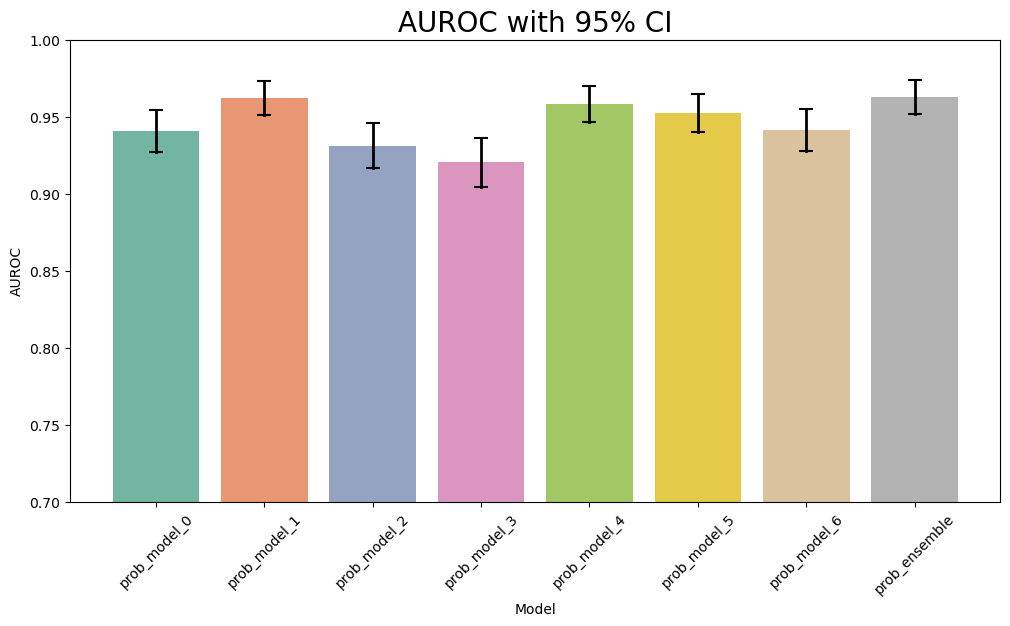

In [5]:
# Calculate AUROC scores with 95% CI
print("\n📊 AUROC Scores (with 95% CI)")
y_true = df['annotation']
auroc_scores = {}
auroc_cis = {}
for col in model_cols + [ensemble_col]:
    # Calculate AUROC
    auroc = roc_auc_score(y_true, df[col])
    auroc_scores[col] = auroc
    
    # Calculate 95% CI using DeLong method approximation
    n1 = sum(y_true == 1)
    n2 = sum(y_true == 0)
    q1 = auroc / (2 - auroc)
    q2 = 2 * (auroc ** 2) / (1 + auroc)
    se = np.sqrt((auroc * (1 - auroc) + (n1 - 1) * (q1 - auroc**2) + (n2 - 1) * (q2 - auroc**2)) / (n1 * n2))
    ci_lower = auroc - 1.96 * se
    ci_upper = auroc + 1.96 * se
    auroc_cis[col] = (ci_lower, ci_upper)
    
    print(f'{col} AUROC: {auroc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})')

# Plot AUROC with 95% CI
plt.figure(figsize=(12, 6))
auroc_df = pd.DataFrame(auroc_scores.items(), columns=["Model", "AUROC"])
auroc_df["CI Lower"], auroc_df["CI Upper"] = zip(*auroc_cis.values())
sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
for i, (ci_lower, ci_upper) in enumerate(auroc_cis.values()):
    plt.plot([i, i], [ci_lower, ci_upper], color="black", linewidth=2)
    plt.scatter([i], [ci_lower], color="black", marker="_", s=100)
    plt.scatter([i], [ci_upper], color="black", marker="_", s=100)
plt.title("AUROC with 95% CI", fontsize=20)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.show()


📊 Sensitivity and Specificity at 95% Thresholds
prob_model_0 - Sensitivity (95% Specificity): 0.6090, Specificity (95% Sensitivity): 0.7791
prob_model_1 - Sensitivity (95% Specificity): 0.8288, Specificity (95% Sensitivity): 0.8655
prob_model_2 - Sensitivity (95% Specificity): 0.5784, Specificity (95% Sensitivity): 0.7662
prob_model_3 - Sensitivity (95% Specificity): 0.5604, Specificity (95% Sensitivity): 0.7259
prob_model_4 - Sensitivity (95% Specificity): 0.7333, Specificity (95% Sensitivity): 0.8647
prob_model_5 - Sensitivity (95% Specificity): 0.6991, Specificity (95% Sensitivity): 0.8313
prob_model_6 - Sensitivity (95% Specificity): 0.6523, Specificity (95% Sensitivity): 0.7734
prob_ensemble - Sensitivity (95% Specificity): 0.7676, Specificity (95% Sensitivity): 0.8568


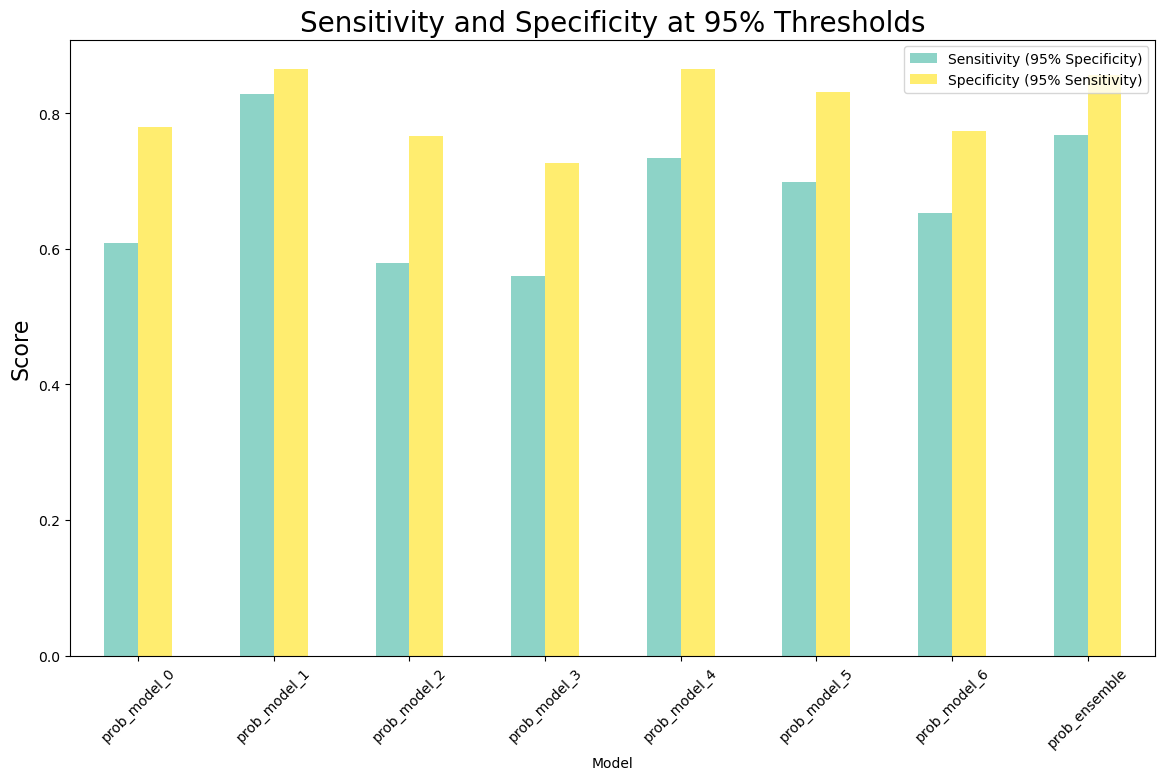

In [6]:
y_true = df['annotation']

# Sensitivity at 95% Specificity & Specificity at 95% Sensitivity
print("\n📊 Sensitivity and Specificity at 95% Thresholds")
threshold_metrics = {}
for col in model_cols + [ensemble_col]:
    fpr, tpr, thresholds = roc_curve(y_true, df[col])

    # Sensitivity at 95% Specificity
    specificity_threshold_idx = np.where(1 - fpr >= 0.95)[0]
    if len(specificity_threshold_idx) > 0:
        sensitivity_95 = max(tpr[specificity_threshold_idx])
    else:
        sensitivity_95 = np.nan  # 또는 0으로 처리

    # Specificity at 95% Sensitivity
    sensitivity_threshold_idx = np.where(tpr >= 0.95)[0]
    if len(sensitivity_threshold_idx) > 0:
        specificity_95 = max(1 - fpr[sensitivity_threshold_idx])
    else:
        specificity_95 = np.nan  # 또는 0으로 처리

    threshold_metrics[col] = (sensitivity_95, specificity_95)
    print(f"{col} - Sensitivity (95% Specificity): {sensitivity_95:.4f}, Specificity (95% Sensitivity): {specificity_95:.4f}")

# Plot Sensitivity and Specificity
threshold_df = pd.DataFrame(threshold_metrics.items(), columns=["Model", "Metrics"])
threshold_df["Sensitivity (95% Specificity)"], threshold_df["Specificity (95% Sensitivity)"] = zip(*threshold_df["Metrics"])
threshold_df.drop(columns=["Metrics"], inplace=True)
threshold_df.set_index("Model", inplace=True)
threshold_df.plot(kind="bar", figsize=(14, 8), colormap="Set3")
plt.title("Sensitivity and Specificity at 95% Thresholds", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Score", fontsize=16)
# plt.ylim(0.2, 1.0)
plt.show()


📊 AUROC Scores
prob_model_0 AUROC: 0.9405
prob_model_1 AUROC: 0.9621
prob_model_2 AUROC: 0.9311
prob_model_3 AUROC: 0.9202
prob_model_4 AUROC: 0.9581
prob_model_5 AUROC: 0.9523
prob_model_6 AUROC: 0.9412
prob_ensemble AUROC: 0.9630


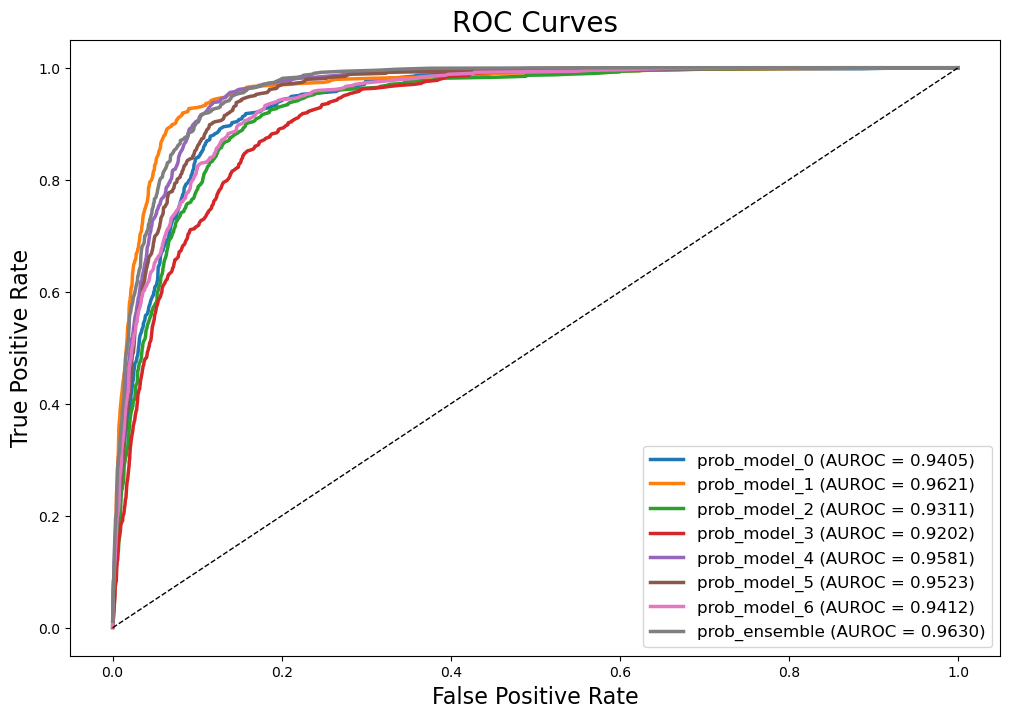

In [7]:
# Calculate AUROC scores
print("\n📊 AUROC Scores")
y_true = df['annotation']
auroc_scores = {}
for col in model_cols + [ensemble_col]:
    auroc_scores[col] = roc_auc_score(y_true, df[col])
    print(f'{col} AUROC: {auroc_scores[col]:.4f}')

# Plot ROC curves (Seaborn)
plt.figure(figsize=(12, 8))
for col in model_cols + [ensemble_col]:
    fpr, tpr, _ = roc_curve(y_true, df[col])
    sns.lineplot(x=fpr, y=tpr, label=f'{col} (AUROC = {auroc_scores[col]:.4f})', linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curves', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()


🔗 Correlation Matrix


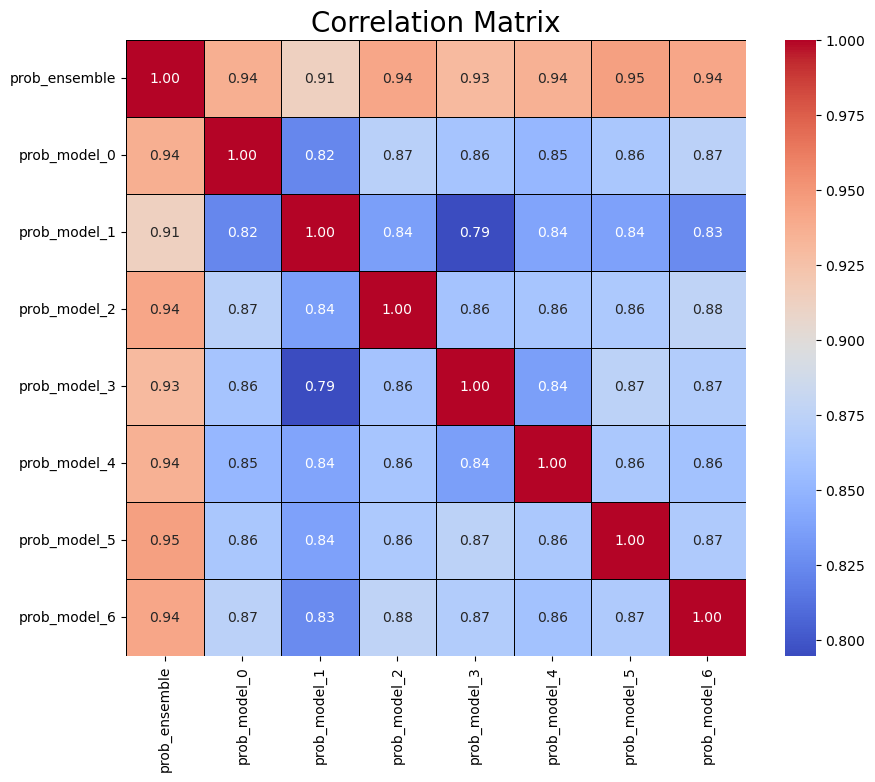

In [8]:
# Correlation matrix (Seaborn)
print("\n🔗 Correlation Matrix")
corr_matrix = df[[ensemble_col] + model_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix', fontsize=20)
plt.show()

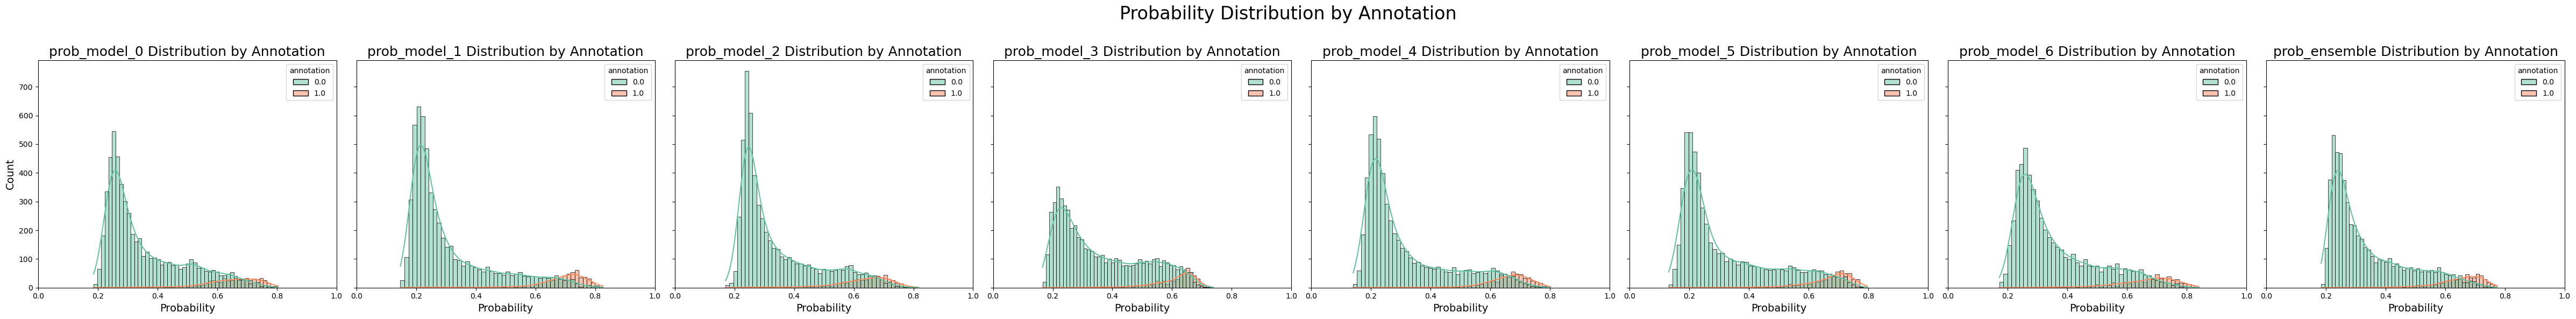

In [9]:
# Probability distribution per annotation (Seaborn, col-wise layout)
_model_cols = model_cols + [ensemble_col]
num_models = len(_model_cols)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    sns.histplot(data=df, x=model_col, hue="annotation", bins=50, kde=True, ax=axes[i], alpha=0.5, palette="Set2")
    axes[i].set_title(f"{model_col} Distribution by Annotation", fontsize=18)
    axes[i].set_xlabel("Probability", fontsize=14)
    axes[i].set_ylabel("Count", fontsize=14)
    axes[i].set_xlim(0.0, 1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

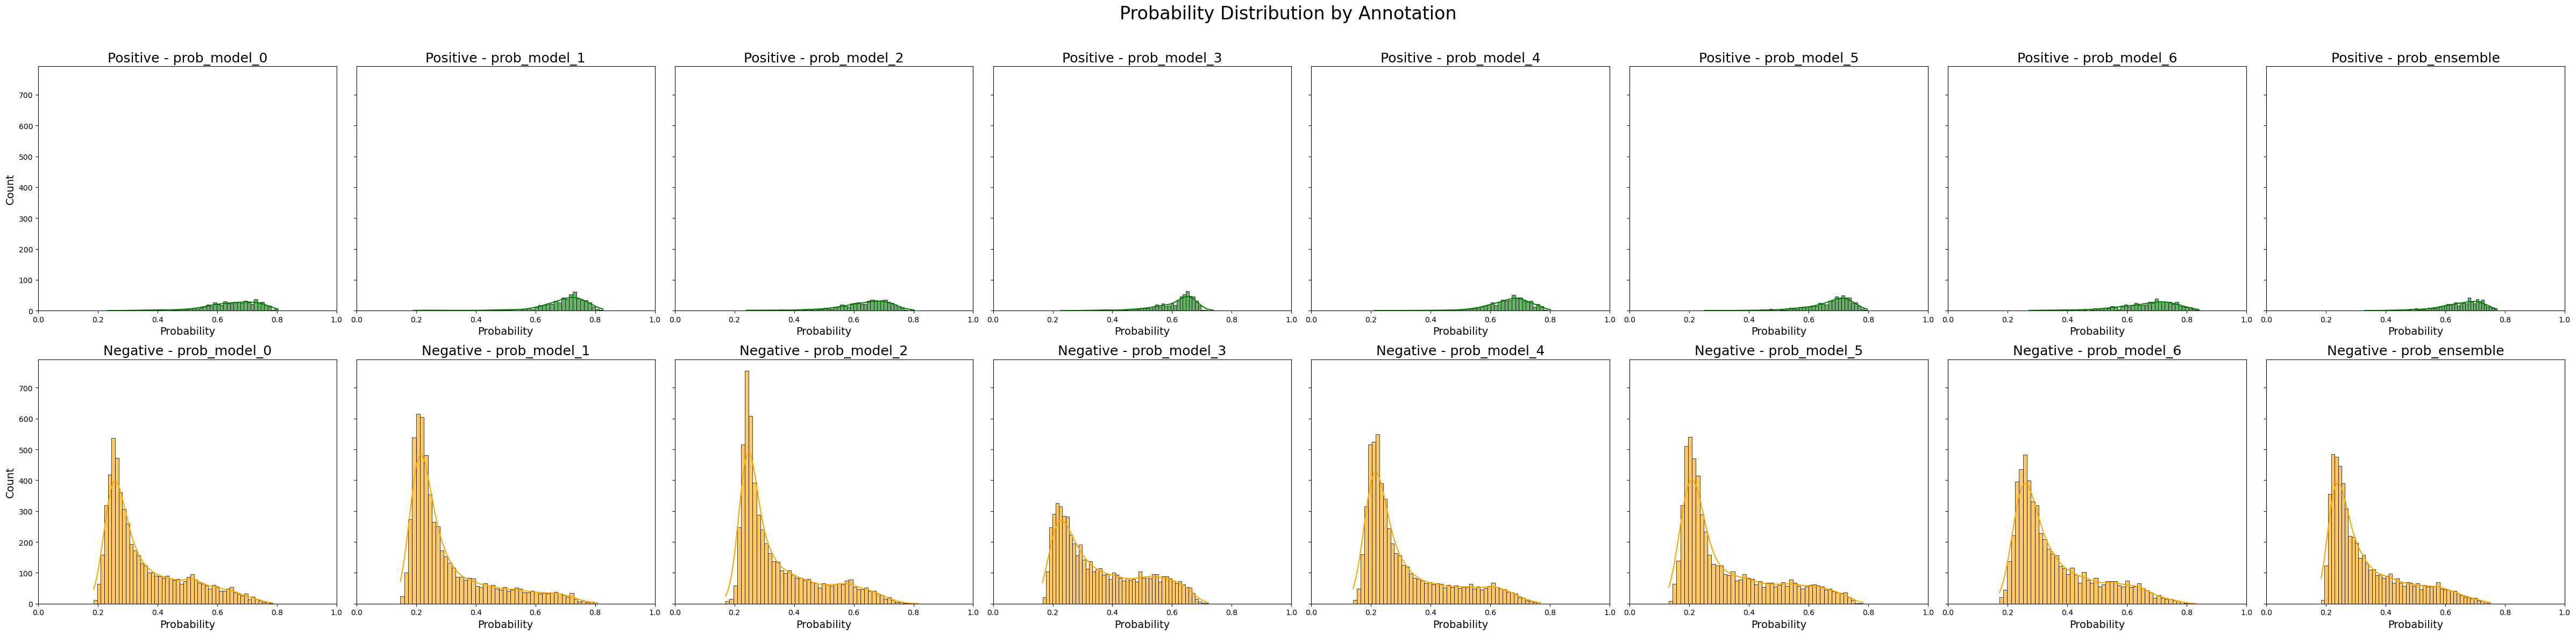

In [10]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
_model_cols = model_cols + [ensemble_col]

# Probability distribution by annotation (Seaborn, row-wise layout)
num_models = len(_model_cols)
fig, axes = plt.subplots(2, num_models, figsize=(6 * num_models, 12), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    # Positive annotation
    sns.histplot(data=df[df['annotation'] == 1], x=model_col, bins=50, kde=True, ax=axes[0, i], alpha=0.6, color="green")
    axes[0, i].set_title(f"Positive - {model_col}", fontsize=18)
    axes[0, i].set_xlabel("Probability", fontsize=14)
    axes[0, i].set_ylabel("Count", fontsize=14)
    axes[0, i].set_xlim(0.0, 1.0)

    # Negative annotation
    sns.histplot(data=df[df['annotation'] == 0], x=model_col, bins=50, kde=True, ax=axes[1, i], alpha=0.6, color="orange")
    axes[1, i].set_title(f"Negative - {model_col}", fontsize=18)
    axes[1, i].set_xlabel("Probability", fontsize=14)
    axes[1, i].set_ylabel("Count", fontsize=14)
    axes[1, i].set_xlim(0.0, 1.0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


🧮 Entropy Analysis

📝 Entropy Summary
       prob_model_0  prob_model_1  prob_model_2  prob_model_3  prob_model_4  \
count   6163.000000   6163.000000   6163.000000   6163.000000   6163.000000   
mean       0.887663      0.828362      0.876367      0.884624      0.838450   
std        0.077378      0.099965      0.080592      0.097716      0.104906   
min        0.693277      0.602864      0.658643      0.647739      0.583501   
25%        0.821375      0.746000      0.805841      0.797528      0.749417   
50%        0.882949      0.811724      0.866655      0.911919      0.827567   
75%        0.962965      0.913661      0.955598      0.976130      0.938269   
max        0.999999      1.000000      1.000000      1.000000      1.000000   

       prob_model_5  prob_model_6  prob_ensemble  
count   6163.000000   6163.000000    6163.000000  
mean       0.835074      0.884025       0.874325  
std        0.112057      0.080753       0.085088  
min        0.559416      0.632399       0.688

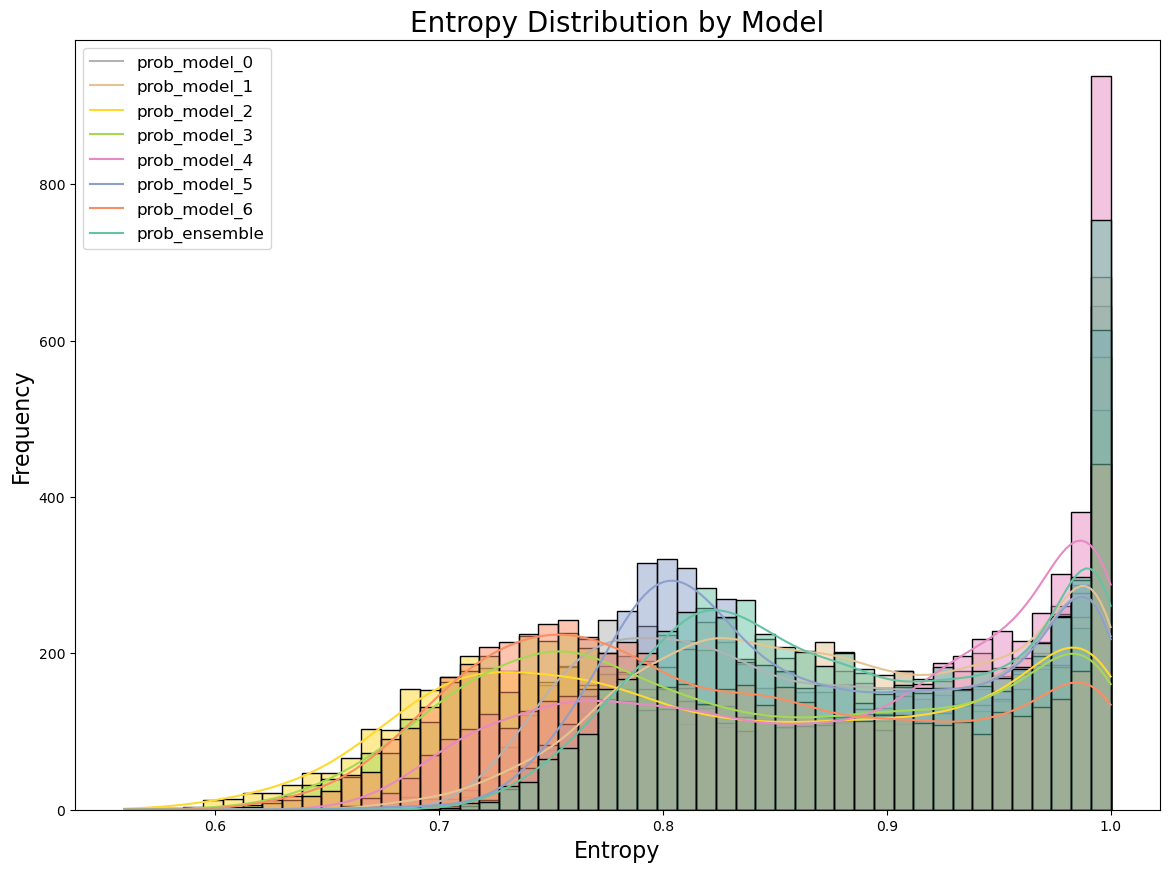

In [11]:
# Entropy calculation
print("\n🧮 Entropy Analysis")
entropy_df = pd.DataFrame()
for col in model_cols + [ensemble_col]:
    probs = df[col].values
    entropies = -(probs * np.log2(probs + 1e-10) + (1 - probs) * np.log2(1 - probs + 1e-10))
    entropy_df[col] = entropies

# Entropy summary
print("\n📝 Entropy Summary")
print(entropy_df.describe())

# Plot entropy distributions (Seaborn)
plt.figure(figsize=(14, 10))
sns.histplot(entropy_df, kde=True, bins=50, alpha=0.5, palette='Set2')
plt.title('Entropy Distribution by Model', fontsize=20)
plt.xlabel('Entropy', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(entropy_df.columns, fontsize=12)
plt.show()

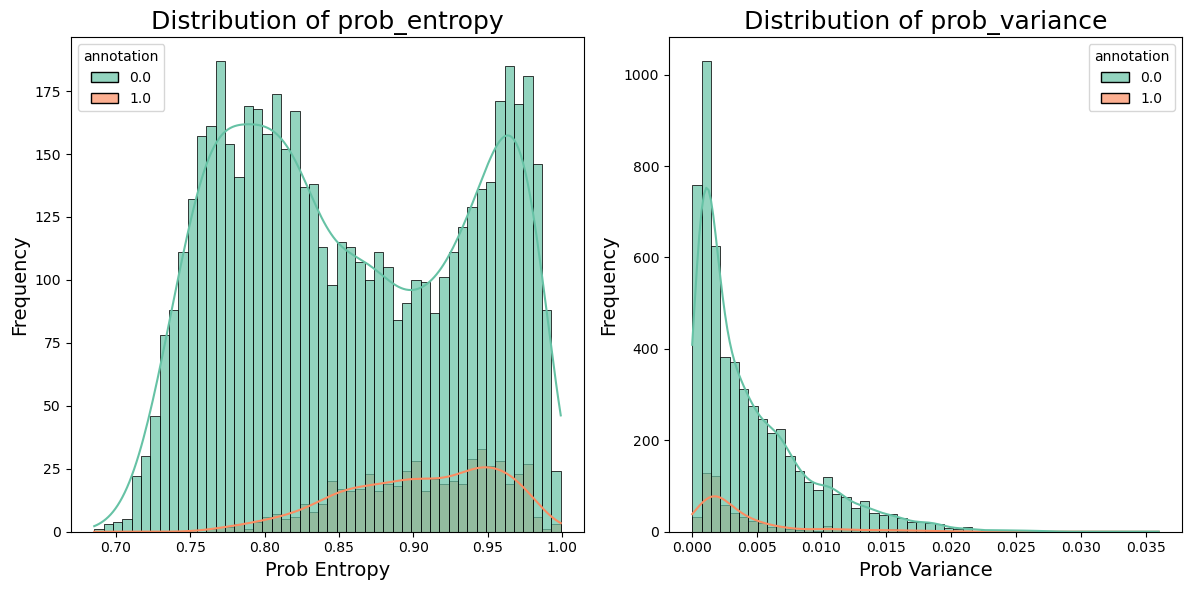


📝 Metric Summary Statistics
       prob_entropy  prob_variance
count   6163.000000    6163.000000
mean       0.862081       0.004419
std        0.078736       0.004404
min        0.685534       0.000040
25%        0.793416       0.001196
50%        0.858230       0.002818
75%        0.937015       0.006321
max        0.999019       0.035979


In [12]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]

# Correct entropy calculation for binary classification
binary_entropies = []
for _, row in df[model_cols].iterrows():
    entropies = - (row.values * np.log2(row.values + 1e-10) + (1 - row.values) * np.log2(1 - row.values + 1e-10))
    binary_entropies.append(np.mean(entropies))

df["prob_entropy"] = binary_entropies
df["prob_variance"] = df[model_cols].var(axis=1)

# Plot distributions
metrics = ["prob_entropy", "prob_variance"]
plt.figure(figsize=(18, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=df, x=metric, hue="annotation", bins=50, kde=True, palette="Set2", alpha=0.7)
    plt.title(f"Distribution of {metric}", fontsize=18)
    plt.xlabel(metric.replace('_', ' ').title(), fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📝 Metric Summary Statistics")
print(df[metrics].describe())

In [13]:
# Sort by entropy, variance, and CV for each annotation
sorted_positive = df[df["annotation"] == 1].sort_values(by="prob_variance", ascending=False)
sorted_negative = df[df["annotation"] == 0].sort_values(by="prob_variance", ascending=False)

# Select top N samples
N = 20
top_positive = sorted_positive.head(N)
top_negative = sorted_negative.head(N)

# Display the selected samples
print("\n🔎 Top Positive Samples (High variance)")
print(top_positive[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))

print("\n🔎 Top Negative Samples (High variance)")
print(top_negative[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))


🔎 Top Positive Samples (High variance)
    annotation  prob_entropy  prob_variance  prob_model_0  prob_model_1  \
0          1.0      0.888059       0.029875      0.663838      0.224119   
1          1.0      0.878988       0.028039      0.646754      0.262154   
2          1.0      0.938937       0.024001      0.572922      0.692017   
3          1.0      0.880785       0.022496      0.721357      0.313155   
4          1.0      0.917568       0.022346      0.286425      0.637698   
5          1.0      0.880755       0.019999      0.698747      0.344587   
6          1.0      0.949649       0.019601      0.577880      0.679856   
7          1.0      0.952403       0.018856      0.416593      0.627671   
8          1.0      0.953001       0.018289      0.528220      0.709688   
9          1.0      0.946051       0.018207      0.559176      0.267938   
10         1.0      0.952893       0.018161      0.563696      0.678024   
11         1.0      0.948468       0.017078      0.606539   

In [14]:
import pymongo

from data_lake.constants import DB_ADDRESS, TARGET_COLLECTION, TARGET_DB

_CLIENT = pymongo.MongoClient(DB_ADDRESS)
_TARGET_FIELD = {}
_PROJECTION = {field: 1 for field in _TARGET_FIELD}

for _, row in top_positive.iterrows():
    query = {"annotation_id": row.annot_ids}
    nodule_candidates = [x for x in _CLIENT[TARGET_DB][TARGET_COLLECTION].find(query, _PROJECTION)]
    break


In [15]:
nodule_candidates

[{'_id': ObjectId('67f76d775ca4e585263d469d'),
  'patient_id': 126823,
  'series_instance_uid': '1.2.840.113654.2.55.84791748489302774443235765573321222490',
  'annotation_id': '126823_1_19990102',
  'studydate': 19990102,
  'h5_path_nfs': '/team/team_blu3/lung/data/2_public/LUNA25_h5/1.2.840.113654.2.55.84791748489302774443235765573321222490.h5',
  'h5_path': '/nvme1/1_dataset/LUNA25_h5/1.2.840.113654.2.55.84791748489302774443235765573321222490.h5',
  'fold': 1,
  'label': 1,
  'age_at_study': 55,
  'gender': 'Female',
  'origin': [-403.6000061035156, -331.6484375, -179.6484375],
  'transform': [[2.0, 0.0, 0.0], [0.0, 0.703125, 0.0], [0.0, 0.0, 0.703125]],
  'spacing': [2.0, 0.703125, 0.703125],
  'resampled_spacing': [1.0, 0.67, 0.67],
  'w_coord_zyx': [-283.6000061, -104.9389191, 57.70991516],
  'd_coord_zyx': [60.000000001757826, 322.43131505777774, 337.57632378311115],
  'r_coord_zyx': [120.32608696004694, 338.2058412347727, 354.09179950635536],
  'fold_10': 1,
  'fold_15': 1}]